In [1]:
import tensorflow as tf
import keras
import skimage.io
import numpy as np
import lime

from lime import lime_image
from lime.wrappers.scikit_image import SegmentationAlgorithm
from matplotlib import pyplot as plt
from skimage.segmentation import mark_boundaries
from tensorflow.keras.applications.inception_v3 import InceptionV3, preprocess_input, decode_predictions

print('Notebook running: tensorflow ', tf.__version__)
print('Notebook running: keras ', keras.__version__)
print('Notebook running: numpy ', np.__version__)

np.random.seed(0)

Notebook running: tensorflow  2.4.1
Notebook running: keras  2.4.3
Notebook running: numpy  1.19.5


In [2]:
#Load pretrained model 

model = InceptionV3()

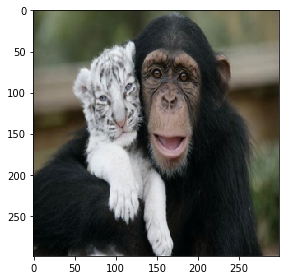

In [3]:
#load image

img = skimage.io.imread('immagine.jpg')
img = skimage.transform.resize(img, (299,299)) #InceptionV3 works with 299x299 images
skimage.io.imshow(img)

In [4]:
#predict and show predictions

preds = model.predict(img[np.newaxis,:,:,:])
decode_predictions(preds,top=10)[0] 

[('n02481823', 'chimpanzee', 0.8670282),
 ('n02480855', 'gorilla', 0.005830252),
 ('n02484975', 'guenon', 0.0036718813),
 ('n02483708', 'siamang', 0.0032601643),
 ('n02480495', 'orangutan', 0.002775575),
 ('n02486261', 'patas', 0.0018741386),
 ('n02488702', 'colobus', 0.00108416),
 ('n02487347', 'macaque', 0.0008899319),
 ('n02128757', 'snow_leopard', 0.00085683004),
 ('n02483362', 'gibbon', 0.000820433)]

In [5]:
#generate superpixels

kernel_size=4
max_dist=100
ratio=0.2
superpixels = skimage.segmentation.quickshift(img, kernel_size=kernel_size,max_dist=max_dist, ratio=ratio)
num_superpixels = np.unique(superpixels).shape[0]
print(num_superpixels)


51


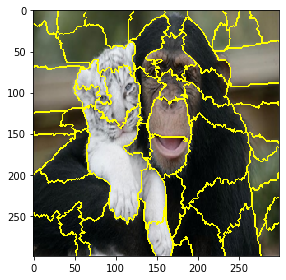

In [6]:
# show segmented image

skimage.io.imshow(skimage.segmentation.mark_boundaries(img, superpixels))

In [7]:
#set segmentation function

seg_fn=SegmentationAlgorithm('quickshift', kernel_size=kernel_size,max_dist=max_dist, ratio=ratio,random_seed=0)

In [8]:
#setting lime as explainier

explainer = lime_image.LimeImageExplainer()

In [9]:
#getting explanation

explanation = explainer.explain_instance(img.astype('double'), model,top_labels=10, hide_color=None, num_samples=1500,segmentation_fn=seg_fn)

100%|██████████| 1500/1500 [00:33<00:00, 44.60it/s]


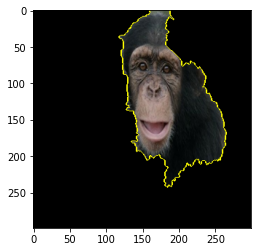

In [10]:
#why chimpanzee?

temp, mask = explanation.get_image_and_mask(explanation.top_labels[0], positive_only=True, num_features=10, hide_rest=True)
plt.imshow(mark_boundaries(temp, mask))

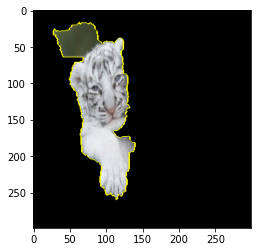

In [11]:
#why snow leopard? ( snow leopard is the 8th index in the model results)

temp, mask = explanation.get_image_and_mask(explanation.top_labels[8], positive_only=True, num_features=5, hide_rest=True)
plt.imshow(mark_boundaries(temp, mask))

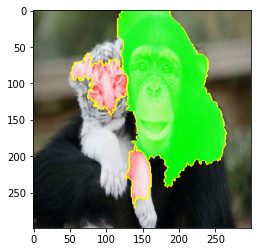

In [12]:
#what are the pros and cons for the chimpanzee choice ? (green is positive and red is negative)

temp, mask = explanation.get_image_and_mask(explanation.top_labels[0], positive_only=False, num_features=15, hide_rest=False)
plt.imshow(mark_boundaries(temp, mask))

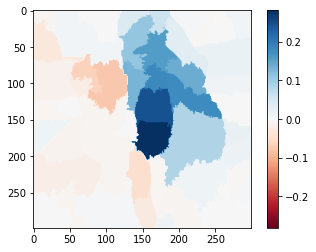

In [13]:
#Select the same class explained on the figures above.
ind =  explanation.top_labels[0]

#Map each explanation weight to the corresponding superpixel
dict_heatmap = dict(explanation.local_exp[ind])
heatmap = np.vectorize(dict_heatmap.get)(explanation.segments) 

#Plot. The visualization makes more sense if a symmetrical colorbar is used.
plt.imshow(heatmap, cmap = 'RdBu', vmin  = -heatmap.max(), vmax = heatmap.max())
plt.colorbar()